# Georcoronal Correction


In [4]:
# import
%matplotlib inline
import os,sys
import matplotlib
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import csv
import pandas as pd
import sfdmap
import extinction
from astropy import units as u
import math
import pylatex

# pyqsofit
from scipy import interpolate

# for SDSS SQL queries
import mechanize
from io import BytesIO

import glob,timeit

#sys.path.append('/Users/runnojc1/Software/py/pyspeckit')
import pyspeckit
from pyspeckit.spectrum.models.inherited_gaussfitter import gaussian
from pyspeckit.specwarnings import PyspeckitWarning
from astropy.table import Table

## Data

In [11]:
file_path = 'ascii/J14301603+2303445_2023-01-06_COS.dat'

t = Table.read(file_path, format='ascii', delimiter='\s', header_start=3, data_start=5)

column_names = ['Wavelength', 'F_lambda', 'e_F_lambda']

original_colnames = t.colnames

for original, new in zip(original_colnames, column_names):
    t.rename_column(original, new)
    
t.sort('Wavelength')

## Find the width of the lines in pixels and Angstroms.


## Projected Aperture Calculation

### Given Data
- **Aperture PSA width:** 0.2 arcseconds
- **COS Platescale:** 23.0 milliarcseconds/pixel = 0.023 arcseconds/pixel
- **Grating G140L Average Dispersion:** 0.6 Angstroms/pixel
- **Central Wavelength:** 800 Angstrom
- 

### Calculation
1. **Calculate the projected aperture width in pixels:**

   $$
   \text{Projected aperture width (pixels)} = \frac{0.2 \text{ arcseconds}}{0.023 \text{ arcseconds per pixel}} = 8.7 \text{ pixels}
   $$

2. **Calculate the projected aperture width in Angstroms:**

   $$
   \text{Projected aperture width (Angstroms)} = 8.7 \text{ pixels} \times 0.6 \text{ Angstroms per pixel} = 5.22 \text{ Angstroms}
   $$



## Creating box profile in spctrum

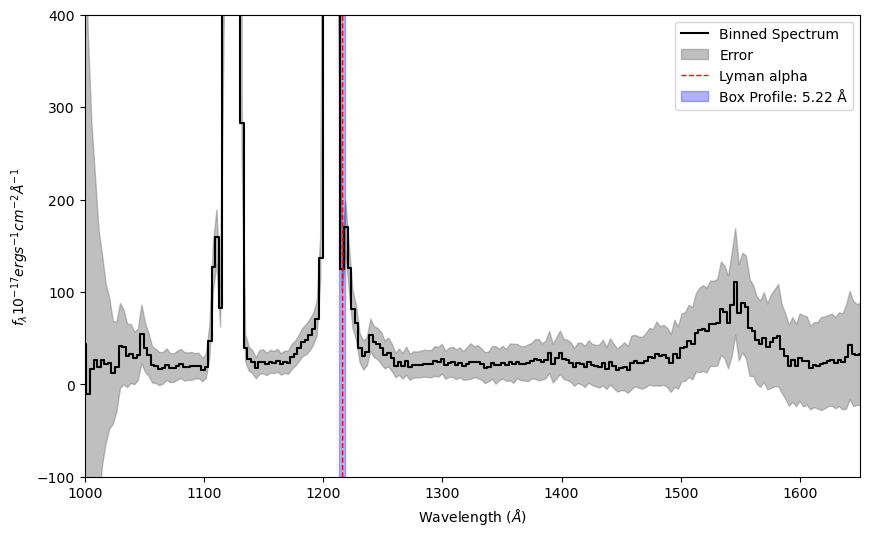

In [12]:
# Binning the data
bin_width = 3
bins = np.arange(min(t["Wavelength"]), max(t["Wavelength"]) + bin_width, bin_width)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

indices = np.digitize(t["Wavelength"], bins)

binned_wl = []
binned_flux = []
binned_flux_err = []

for i in range(1, len(bins)):
    in_bin = indices == i
    if np.any(in_bin):
        binned_wl.append(np.mean(t["Wavelength"][in_bin]))
        binned_flux.append(np.mean(t["F_lambda"][in_bin]))
        binned_flux_err.append(np.mean(t["e_F_lambda"][in_bin]))

binned_wl = np.array(binned_wl)
binned_flux = np.array(binned_flux)
binned_flux_err = np.array(binned_flux_err)

# Plotting the binned spectrum
plt.figure(figsize=(10, 6))
plt.plot(binned_wl, binned_flux, label='Binned Spectrum', color="black", drawstyle='steps-mid')
plt.fill_between(binned_wl, binned_flux - binned_flux_err, binned_flux + binned_flux_err, color='gray', alpha=0.5, label='Error')
plt.axvline(x=1216, color='r', linestyle='--', linewidth=1, label="Lyman alpha")

# Projected Aperture Calculation
aperture_width_arcseconds = 0.2
cos_platescale_arcseconds_per_pixel = 0.023
grating_dispersion_angstroms_per_pixel = 0.6

# Calculate the projected aperture width in pixels
projected_aperture_width_pixels = aperture_width_arcseconds / cos_platescale_arcseconds_per_pixel

# Calculating the projected aperture width in Angstroms
projected_aperture_width_angstroms = projected_aperture_width_pixels * grating_dispersion_angstroms_per_pixel

# Define the box profile dimensions
central_wavelength = 1216
half_box_width_angstroms = projected_aperture_width_angstroms / 2

# Plot the box profile
plt.axvspan(central_wavelength - half_box_width_angstroms, central_wavelength + half_box_width_angstroms,
            color='blue', alpha=0.3, label=f'Box Profile: {projected_aperture_width_angstroms:.2f} Å')

plt.xlabel("Wavelength ($\AA$)")
plt.ylabel("$f_{\lambda} 10^{-17} erg s^{-1} cm^{-2} \AA^{-1}$")
plt.xlim(1000, 1650)
plt.ylim(-100, 400)
plt.legend()
plt.show()

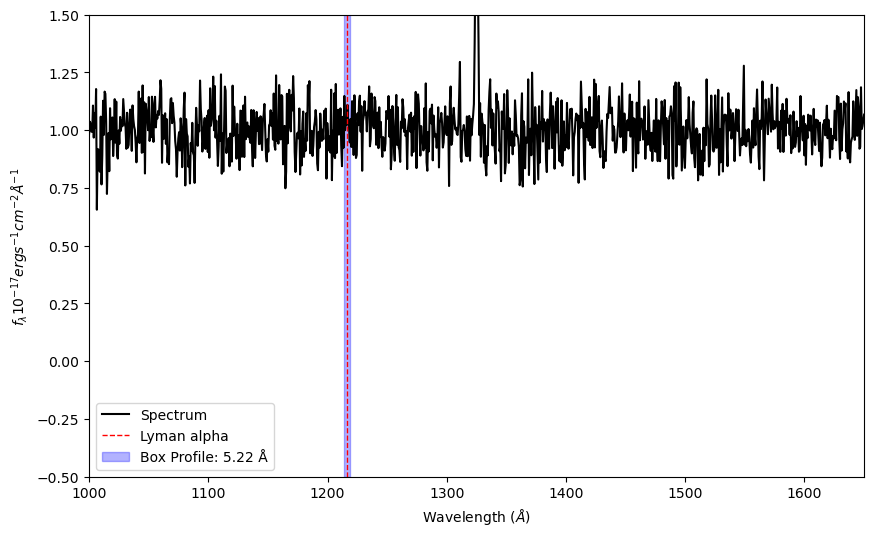

In [13]:
# Example spectrum data (replace with your actual data)
wavelengths = np.linspace(1000, 1650, 1000)  # Example wavelength range from 1000 to 1650 Angstroms
spectrum = np.random.normal(1, 0.1, size=1000)  # Example spectrum with noise
spectrum[490:510] += np.exp(-0.5 * ((np.linspace(0, 1, 20) - 0.5) / 0.1) ** 2)  # Add a Gaussian peak at 1216 Angstroms

# Example parameters
central_wavelength = 1216  # Lyman alpha line
line_width_angstroms = 5.22
dispersion_angstroms_per_pixel = (wavelengths[1] - wavelengths[0])  # Calculate from the wavelength array

# Calculate the box dimensions
box_width_angstroms = line_width_angstroms
half_box_width_angstroms = box_width_angstroms / 2

# Plotting the spectrum
plt.figure(figsize=(10, 6))
plt.plot(wavelengths, spectrum, label='Spectrum', color="black")
plt.axvline(x=1216, color='r', linestyle='--', linewidth=1, label="Lyman alpha")

# Plotting the box profile indicator
plt.axvspan(central_wavelength - half_box_width_angstroms, central_wavelength + half_box_width_angstroms,
            color='blue', alpha=0.3, label=f'Box Profile: {box_width_angstroms:.2f} Å')

plt.xlabel("Wavelength ($\AA$)")
plt.ylabel("$f_{\lambda} 10^{-17} erg s^{-1} cm^{-2} \AA^{-1}$")
plt.xlim(1000, 1650)
plt.ylim(-0.5, 1.5)
plt.legend()
plt.show()